# Spatial Analysis of Breast Cancer Microenvironment


In this exercise, you will analyze spatial transcriptomics data from breast cancer tissue to identify tumor microenvironment components, visualize tumor heterogeneity, and detect interaction patterns between tumor and immune cells.


In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import squidpy as sq
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


# Load the breast cancer dataset
adata_bc = sq.datasets.visium_fluo_adata()

Dataset shape: (2800, 16562)
Available annotations: ['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster']


/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_26778/3748696719.py:14: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_bc, img_key="hires", size=1.5)


<Figure size 1200x1000 with 0 Axes>

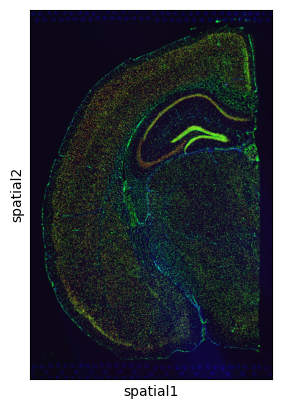

In [ ]:
# Basic data exploration
print(f"Dataset shape: {adata_bc.shape}")
print(f"Available annotations: {list(adata_bc.obs.columns)}")

# Preprocess data
sc.pp.normalize_total(adata_bc, target_sum=1e4)
sc.pp.log1p(adata_bc)
sc.pp.highly_variable_genes(adata_bc, n_top_genes=2000)
adata_bc_hvg = adata_bc[:, adata_bc.var.highly_variable]
sc.pp.scale(adata_bc_hvg)

# View tissue structure
plt.figure(figsize=(12, 10))
sc.pl.spatial(adata_bc, img_key="hires", size=1.5)

In [ ]:
# Prepare data for neural network
X_bc = adata_bc_hvg.X.copy()

# For simplicity, we'll use unsupervised approach with autoencoder
# Define a simple autoencoder
input_dim = X_bc.shape[1]
encoding_dim = 64

# Encoder
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(256, activation="relu")(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(encoding_dim, activation="relu")(encoder)

# Decoder
decoder = tf.keras.layers.Dense(256, activation="relu")(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
output_layer = tf.keras.layers.Dense(input_dim, activation="sigmoid")(decoder)

# Autoencoder model
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

# Train autoencoder
autoencoder.fit(
    X_bc, X_bc, epochs=20, batch_size=64, shuffle=True, validation_split=0.2
)

# Create a model to extract the encoded features
encoder_model = tf.keras.models.Model(inputs=input_layer, outputs=encoder)
encoded_features = encoder_model.predict(X_bc)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1134 - val_loss: 0.9834
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9880 - val_loss: 0.9780
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9931 - val_loss: 0.9732
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0061 - val_loss: 0.9710
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9722 - val_loss: 0.9689
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9774 - val_loss: 0.9682
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9716 - val_loss: 0.9672
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9777 - val_loss: 0.9658
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9665 - val_loss: 0.9646
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9700 - val_loss: 0.9639
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9551 - val_loss: 0.9632
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9557 - val_lo

In [ ]:
# Get the first and second hidden layers outputs as well
intermediate_layer_model = tf.keras.models.Model(
    inputs=input_layer,
    outputs=[autoencoder.layers[1].output, autoencoder.layers[3].output],
)
first_layer_output, second_layer_output = intermediate_layer_model.predict(X_bc)

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from trimap import TRIMAP

raw_tsne = TSNE(n_components=2, random_state=42)
raw_tsne_embedding = raw_tsne.fit_transform(adata_bc_hvg.X.copy())
raw_umap = UMAP(n_components=2, random_state=42)
raw_umap_embedding = raw_umap.fit_transform(adata_bc_hvg.X.copy())
raw_trimap = TRIMAP(n_dims=2)
raw_trimap_embedding = raw_trimap.fit_transform(adata_bc_hvg.X.copy())


In [ ]:
methods = {"t-SNE": TSNE, "UMAP": UMAP, "TRIMAP": TRIMAP}
data = {
    "raw_data": adata_bc_hvg.X.copy(),
    "First Layer Output": first_layer_output,
    "Second Layer Output": second_layer_output,
}
results = {}

for method in methods:
    results[method] = []
    for dataset in data:
        if method != "TRIMAP":
            results[method].append(
                methods[method](n_components=2, random_state=42).fit_transform(
                    data[dataset]
                )
            )
        else:
            results[method].append(
                methods[method](n_dims=2).fit_transform(data[dataset])
            )


/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:337: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:337: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:337: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:338: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:338: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:338: RuntimeWarning: inval

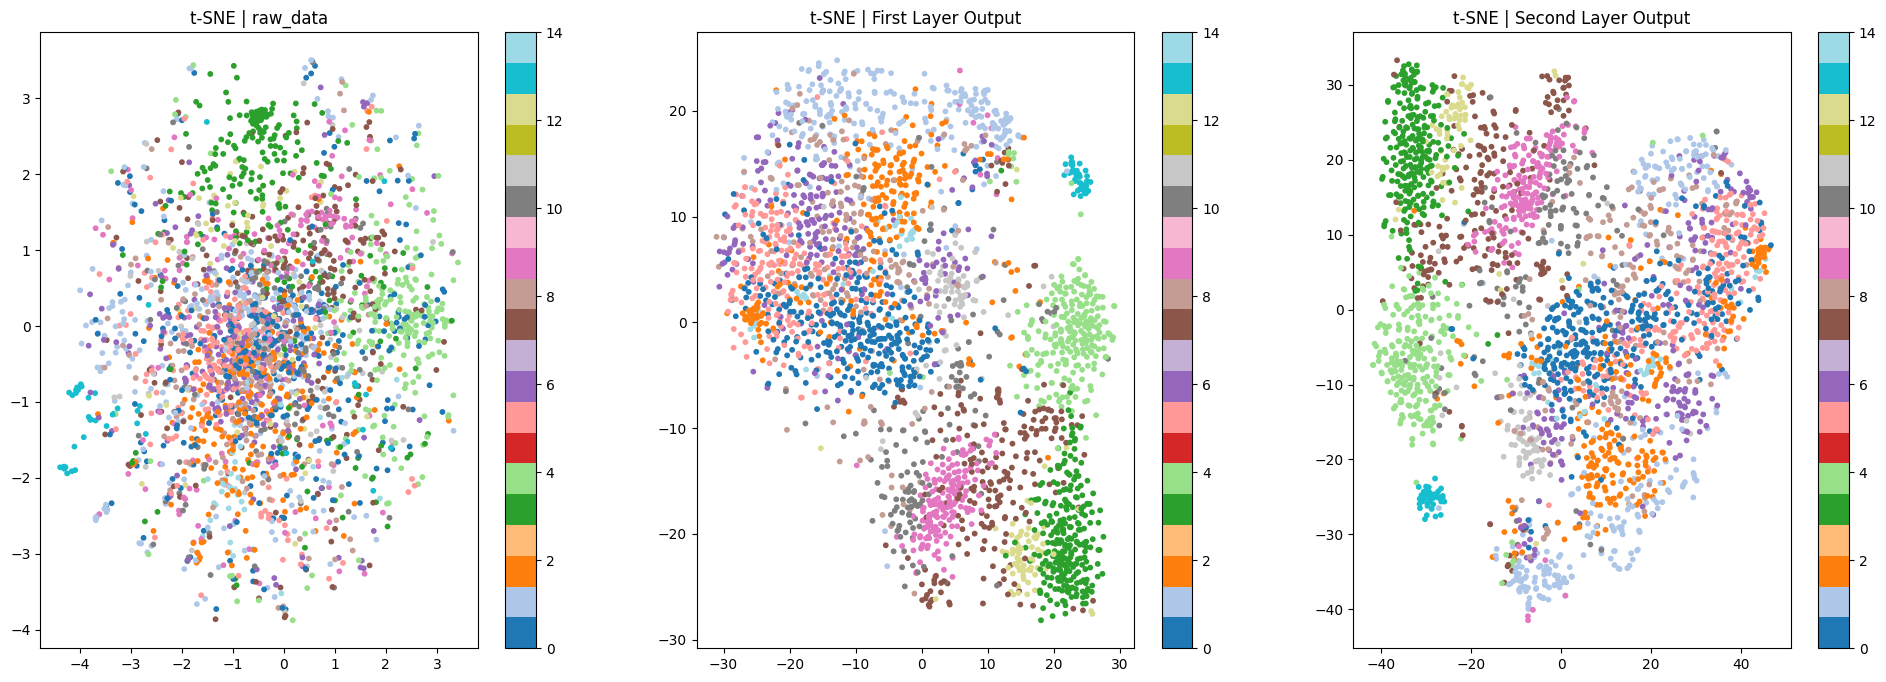

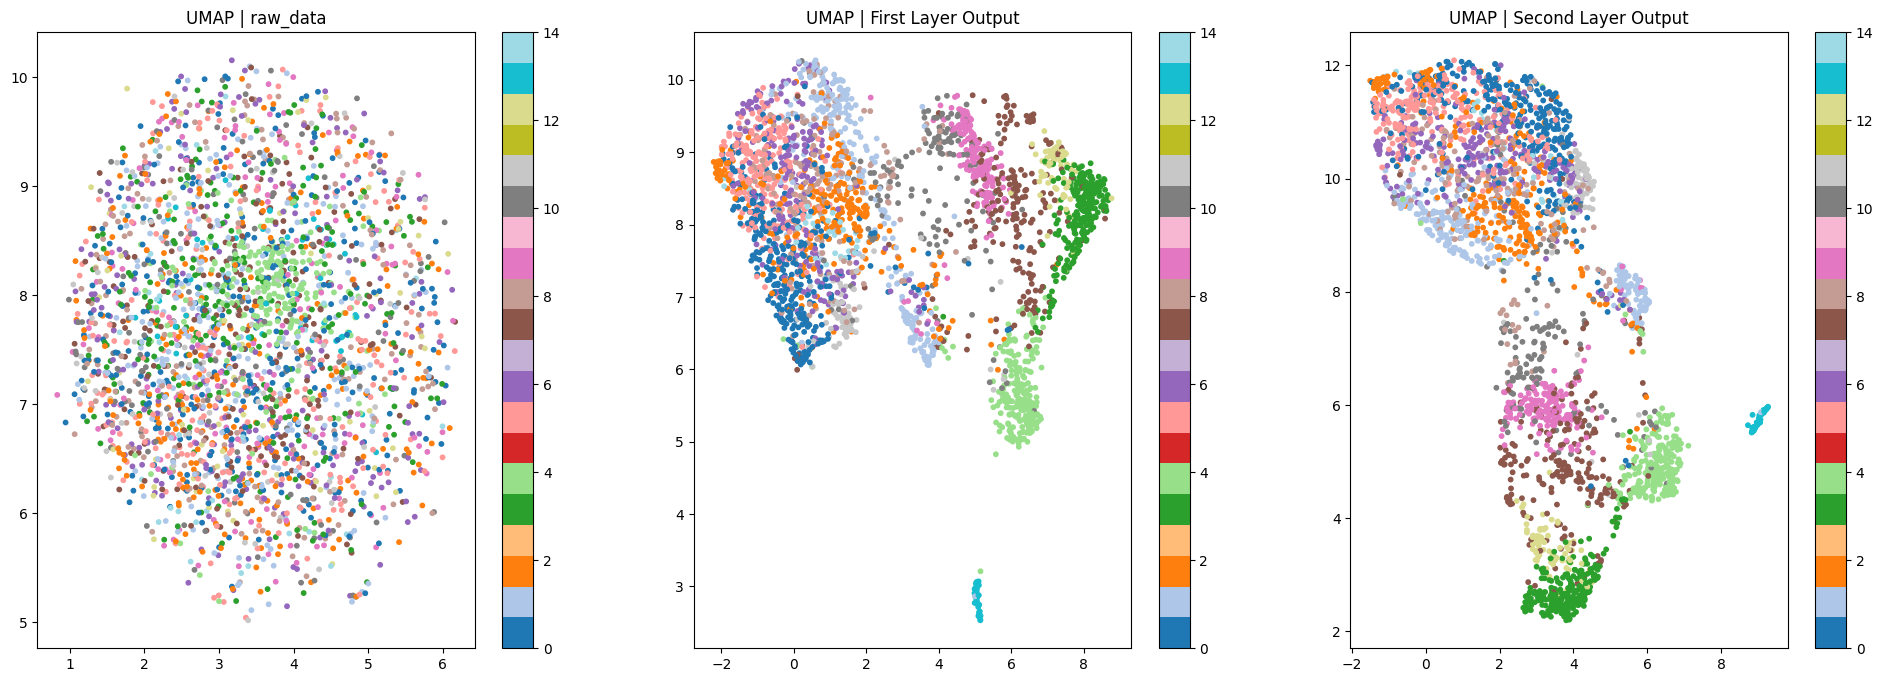

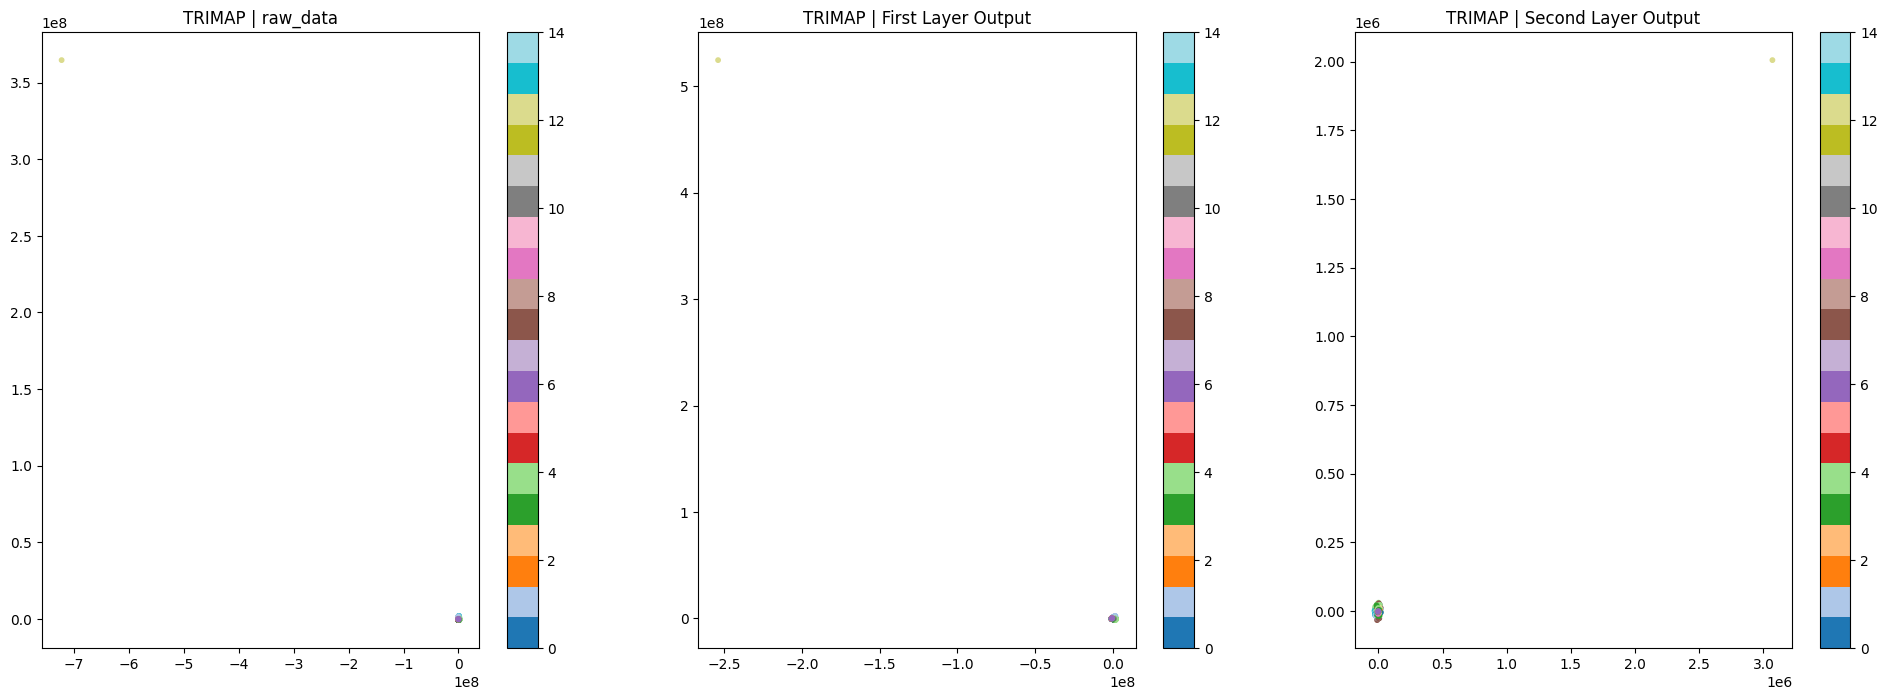

In [ ]:
for method in methods.keys():
    plt.figure(figsize=(24, 8))
    for idx, result in enumerate(results[method]):
        plt.subplot(1, 3, idx + 1)
        plt.scatter(
            result[:, 0],
            result[:, 1],
            c=adata_bc_hvg.obs["leiden"].astype(int),
            cmap="tab20",
            s=10,
        )
        plt.colorbar()
        plt.title(f"{method} | {list(data.keys())[idx]}")
    plt.show()

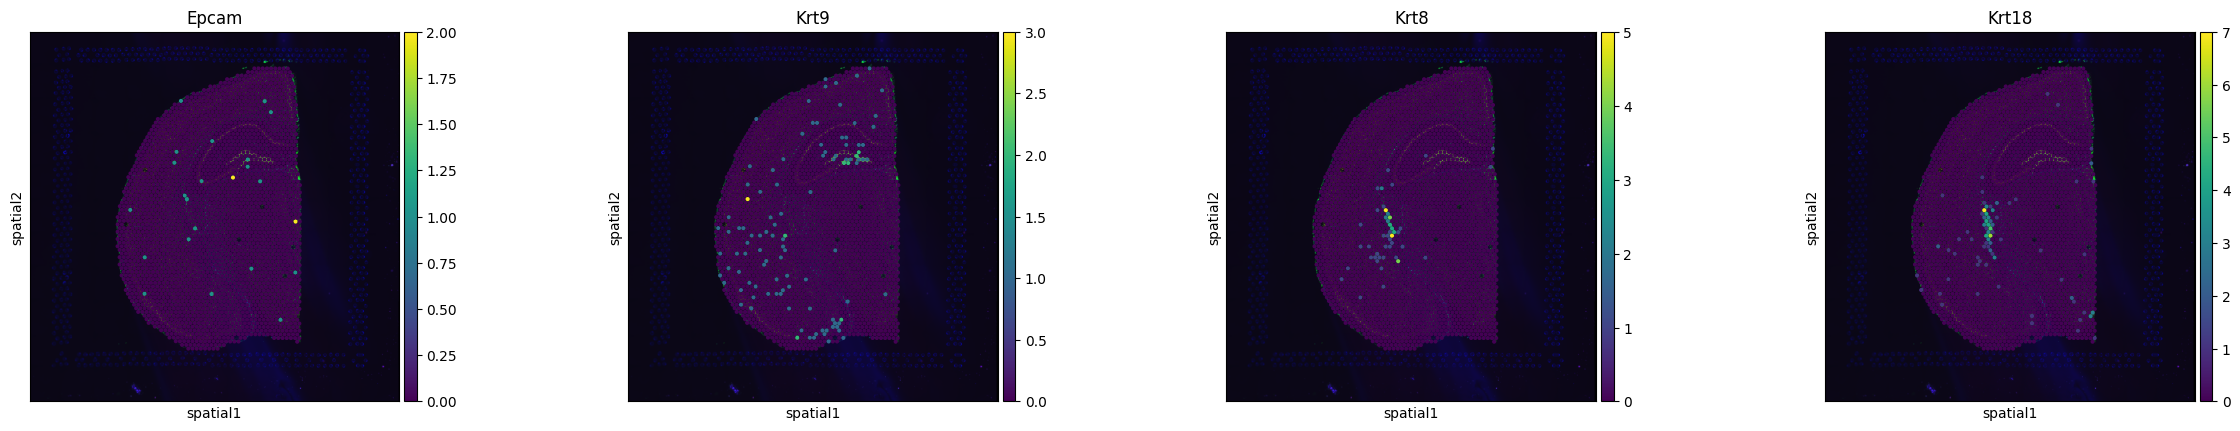

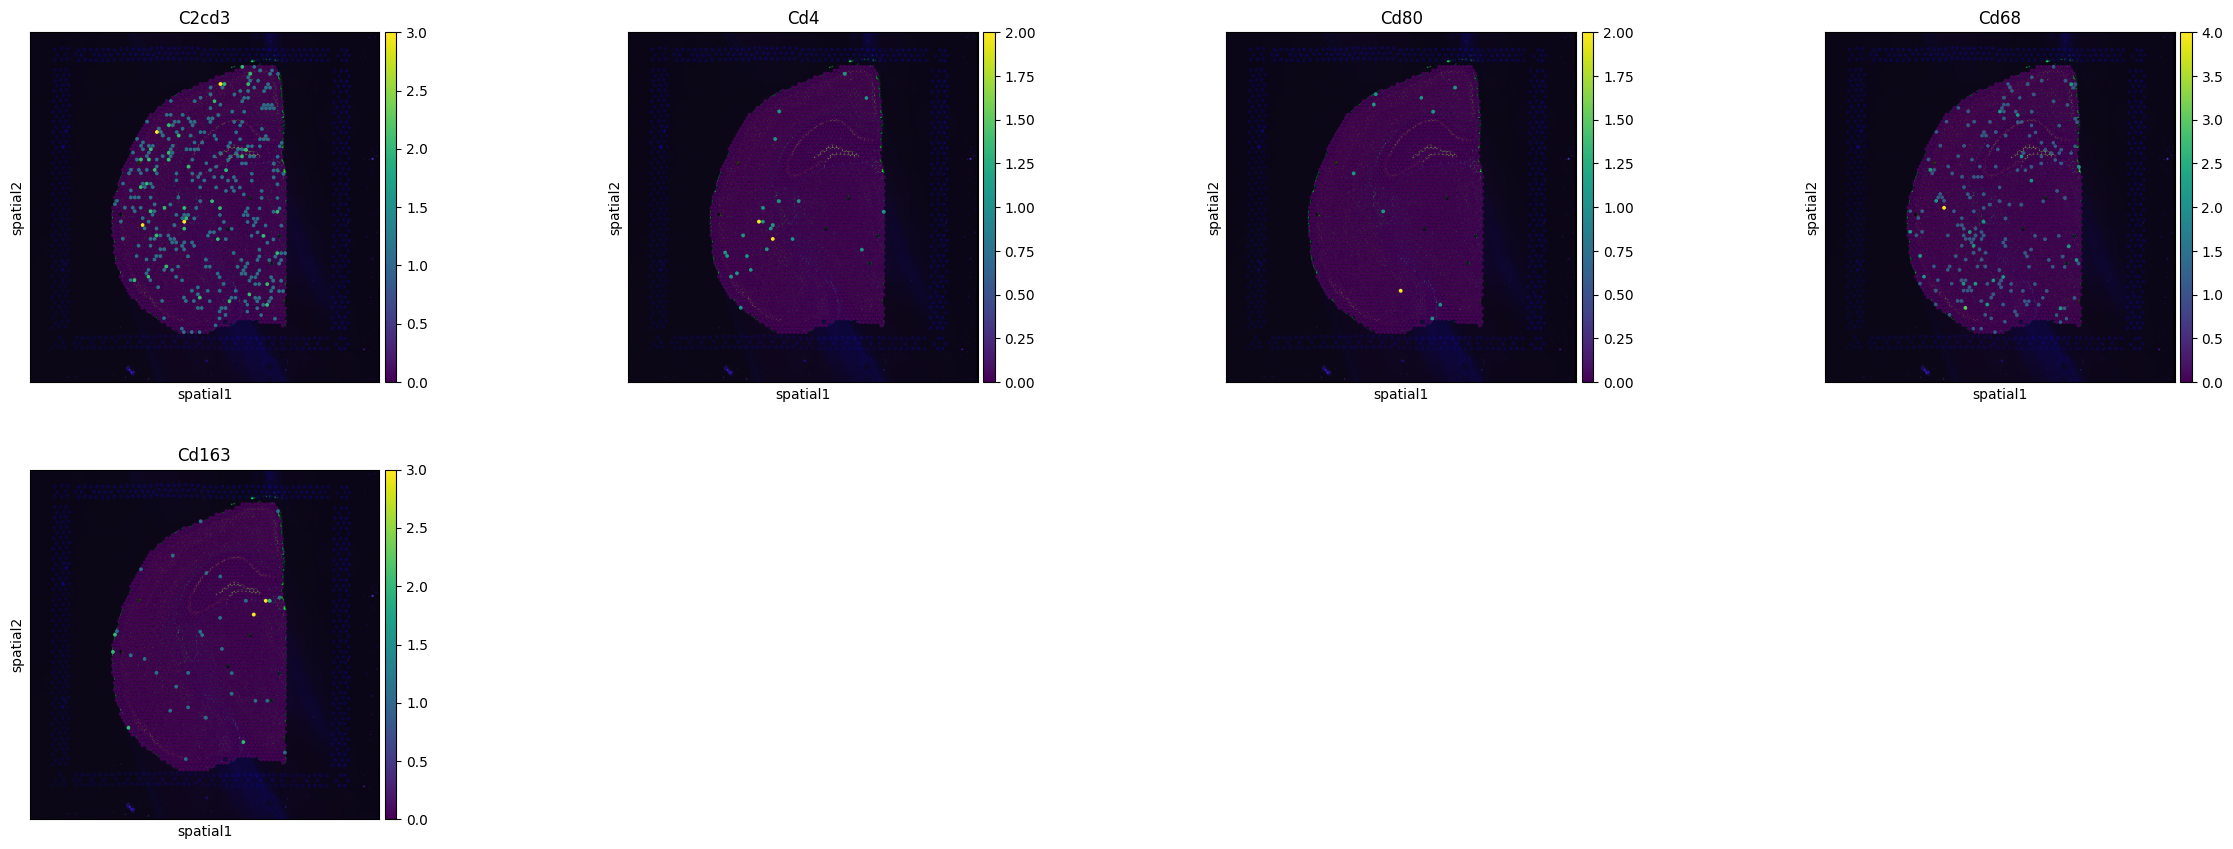

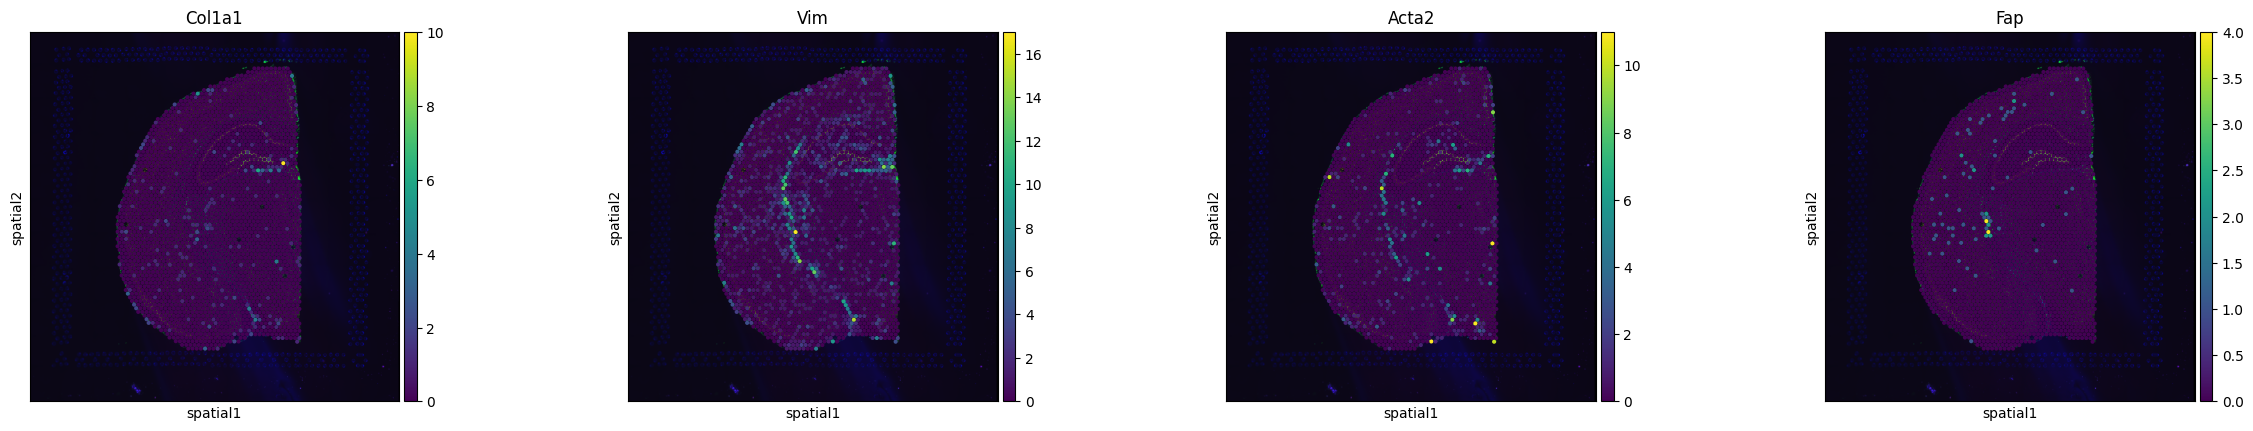

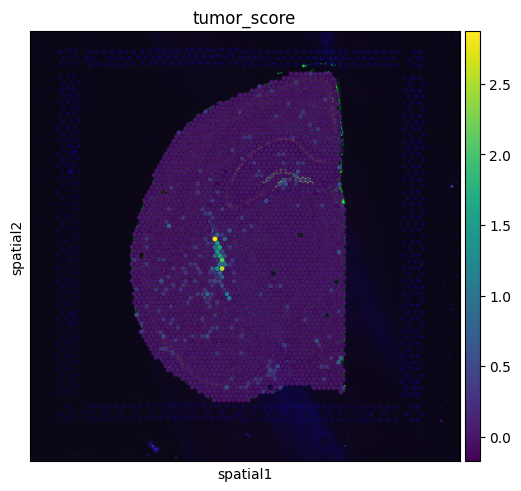

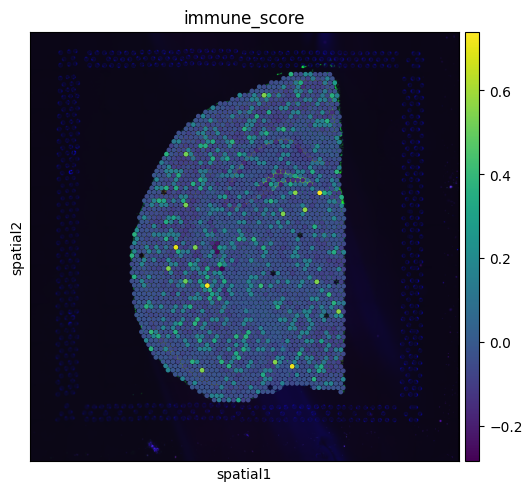

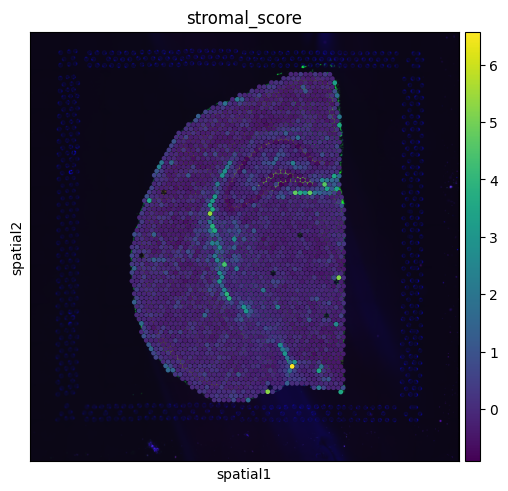

In [ ]:
# Define marker genes for different cell types
tumor_markers = ["Epcam", "Krt9", "Krt8", "Krt18"]
immune_markers = ["C2cd3", "Cd4", "Cd80", "Cd68", "Cd163"]
stromal_markers = ["Col1a1", "Vim", "Acta2", "Fap"]

# Calculate scores for each cell type
sc.tl.score_genes(adata_bc, tumor_markers, score_name="tumor_score")
sc.tl.score_genes(adata_bc, immune_markers, score_name="immune_score")
sc.tl.score_genes(adata_bc, stromal_markers, score_name="stromal_score")

# Visualize marker gene expression and scores
for idx, marker in enumerate([tumor_markers, immune_markers, stromal_markers]):
    sq.pl.spatial_scatter(adata_bc, color=marker, size=1.5)

# Visualize cell type scores
sq.pl.spatial_scatter(adata_bc, color="tumor_score", size=1.5)
sq.pl.spatial_scatter(adata_bc, color="immune_score", size=1.5)
sq.pl.spatial_scatter(adata_bc, color="stromal_score", size=1.5)

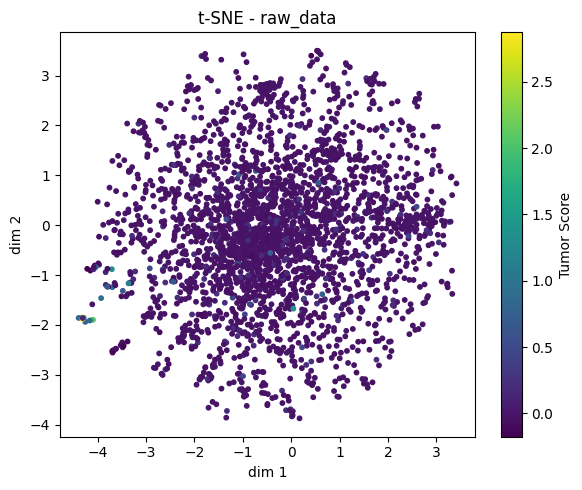

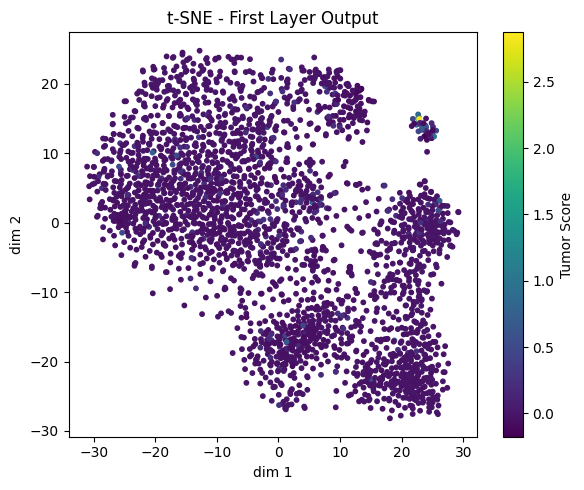

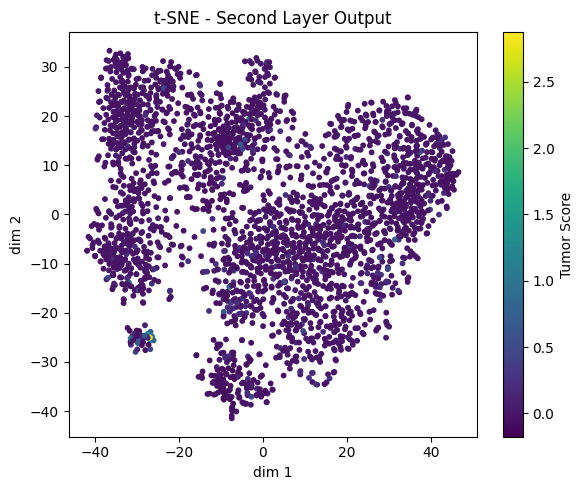

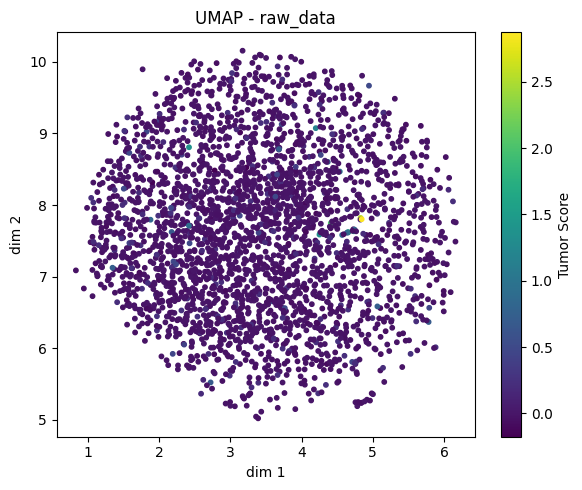

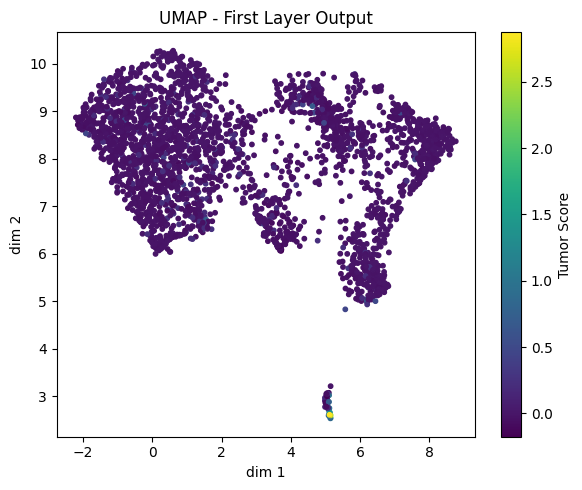

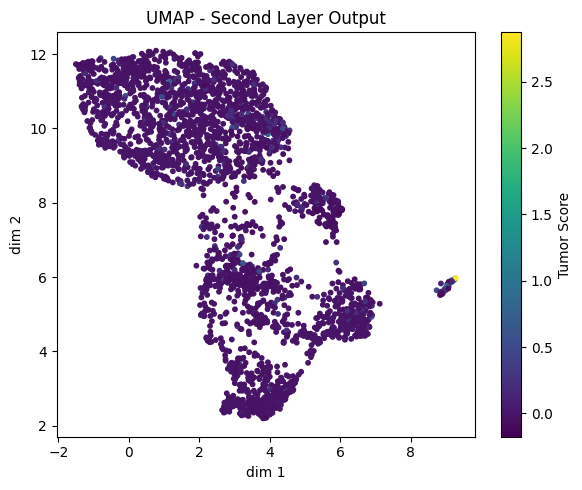

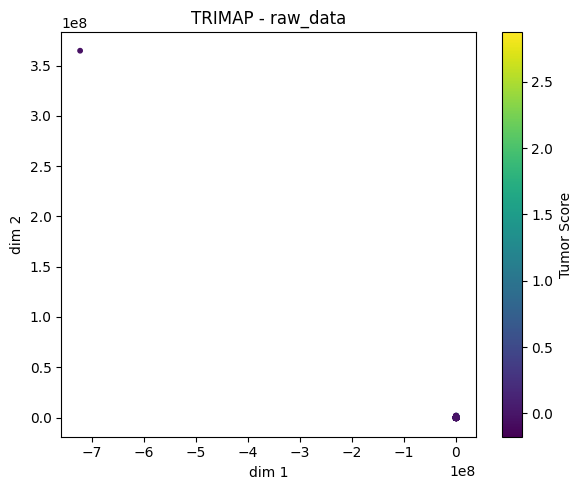

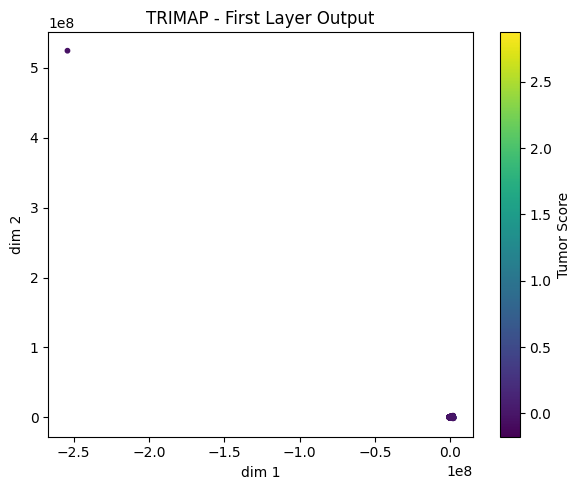

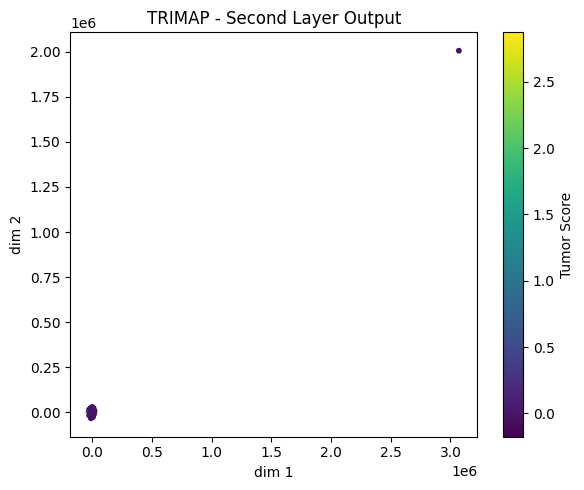

In [ ]:
labels = list(data.keys())

for method in results:
    for i, embedding in enumerate(results[method]):
        plt.figure(figsize=(6, 5))
        plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=adata_bc.obs["tumor_score"],
            cmap="viridis",
            s=10,
        )
        plt.colorbar(sc, label="Tumor Score")
        plt.title(f"{method} | {labels[i]}")
        plt.xlabel("dim 1")
        plt.ylabel("dim 2")
        plt.tight_layout()
        plt.show()


/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:337: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:337: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:337: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:338: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:338: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/nicolas/studia/I_sem/wdzd/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:338: RuntimeWarning: inval

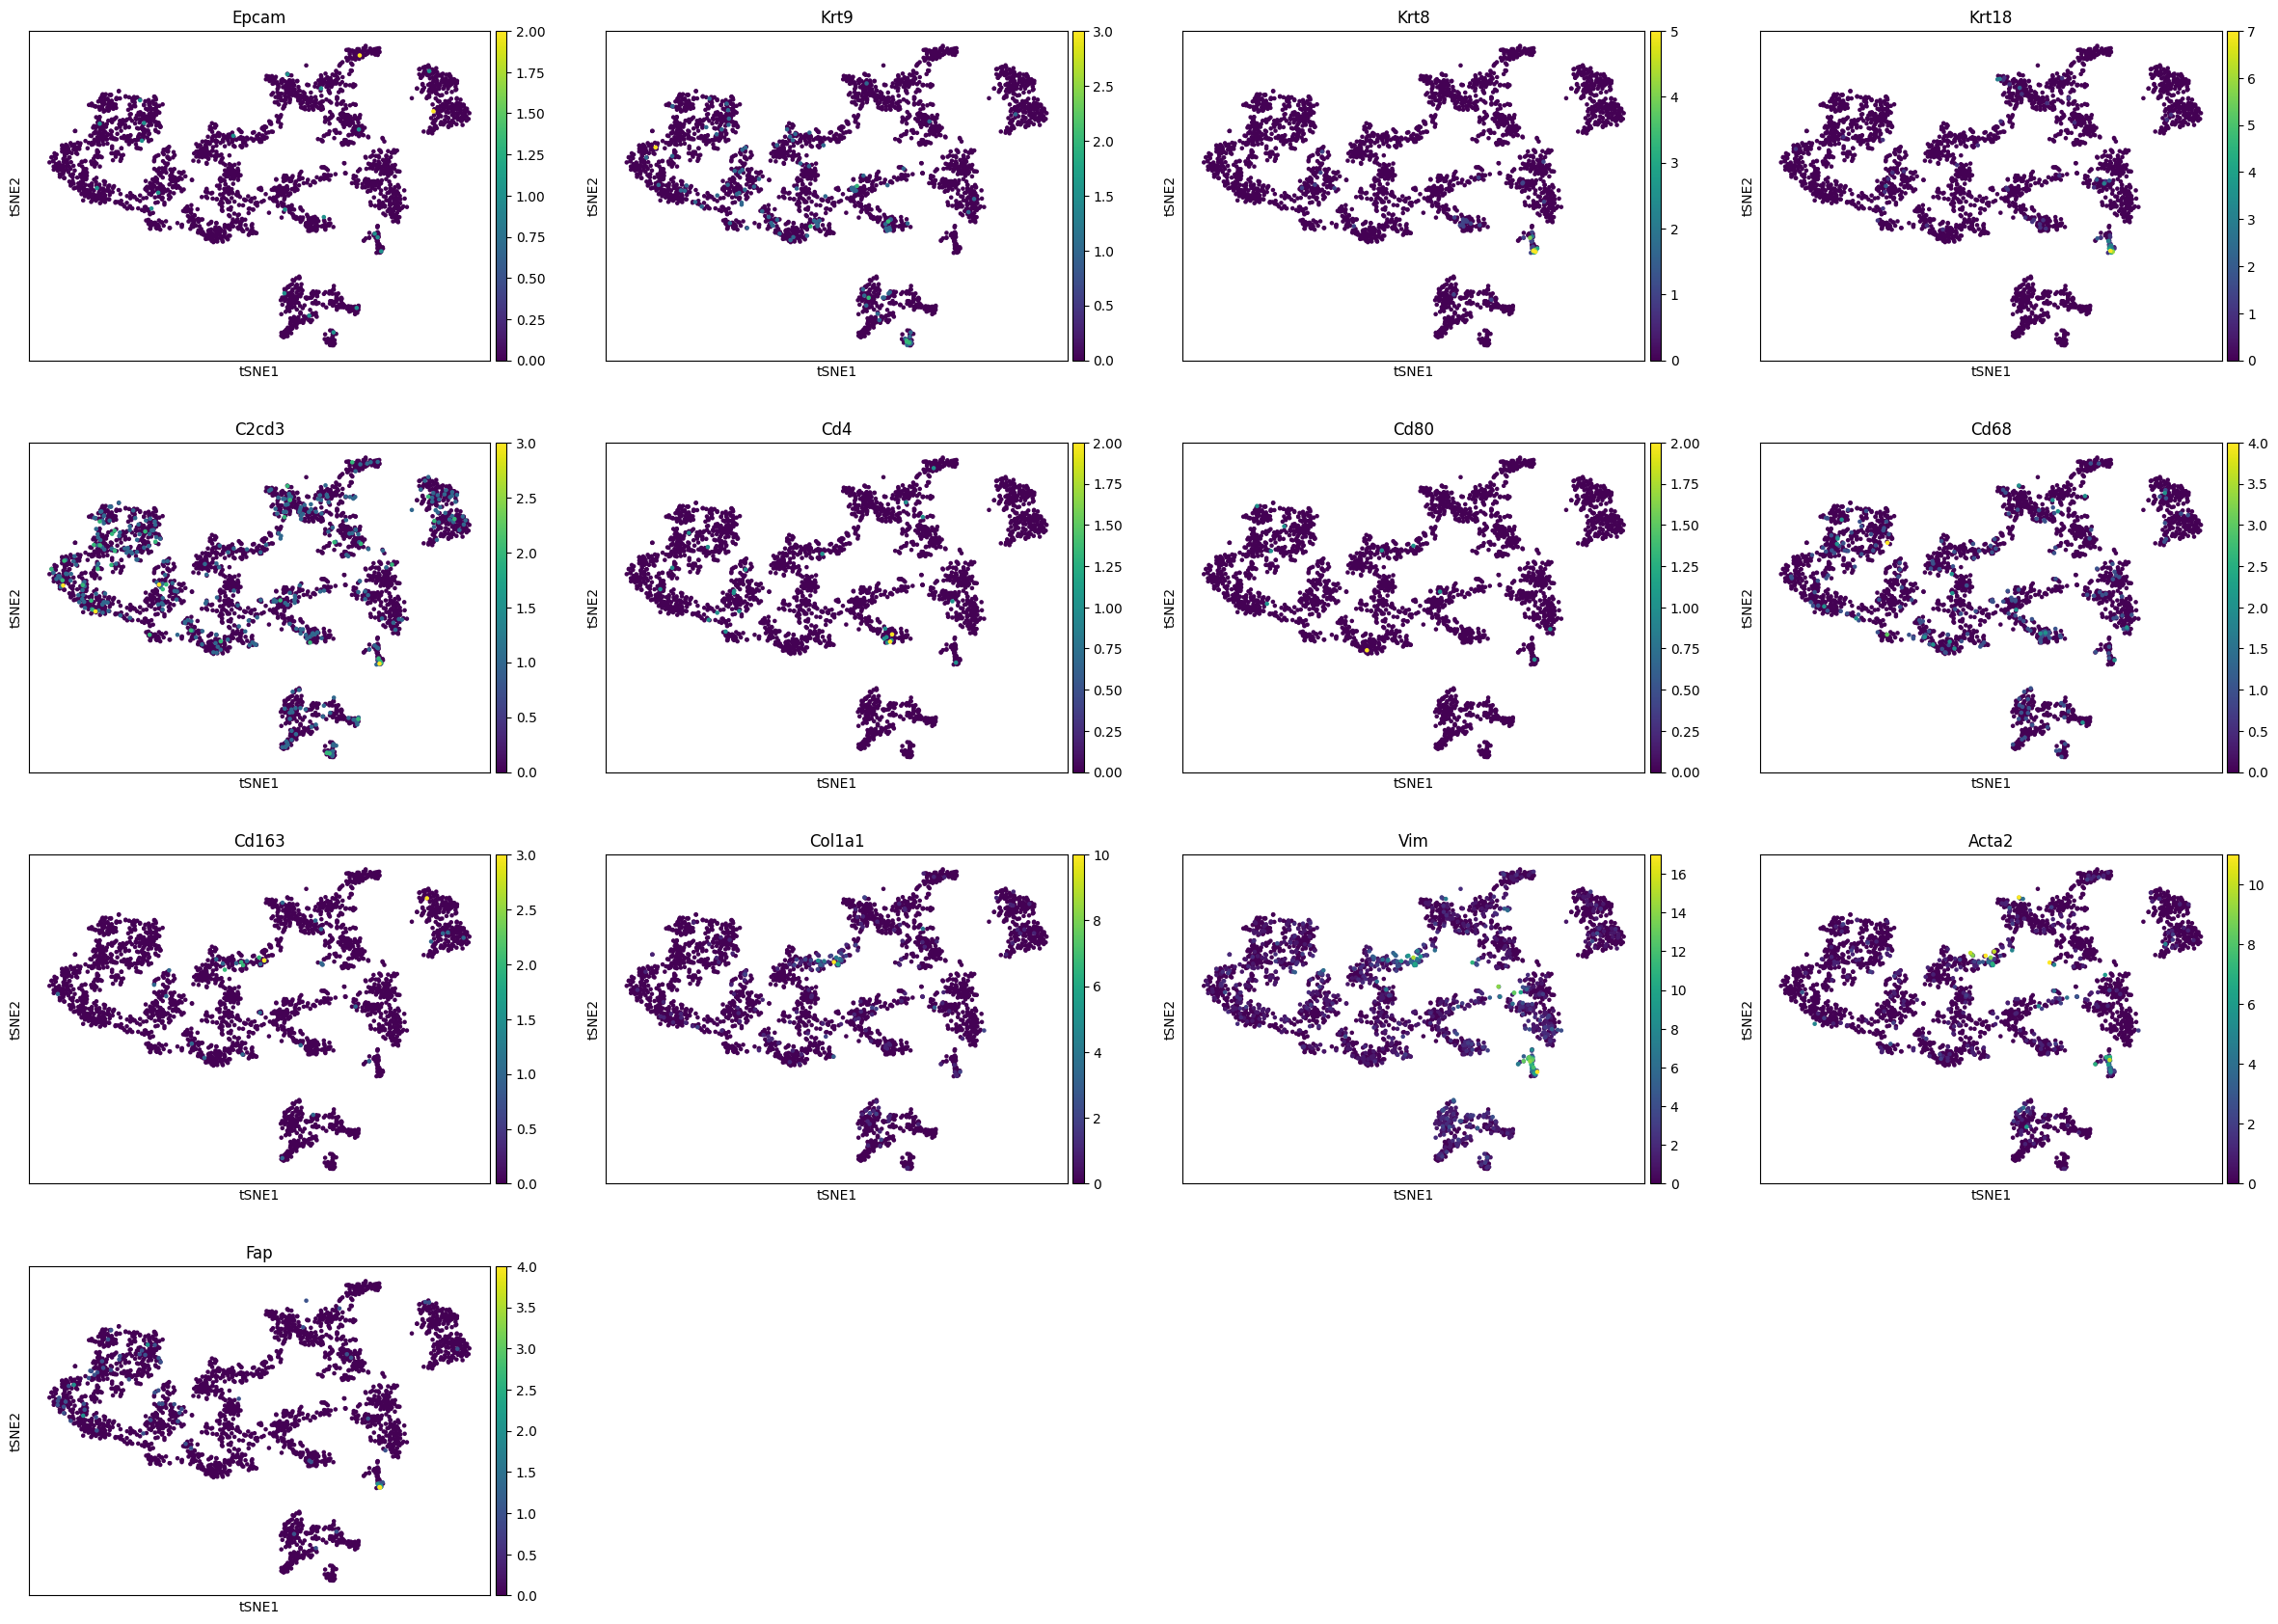

In [ ]:
sc.tl.tsne(adata_bc)
sc.pl.embedding(
    adata_bc, basis="tsne", color=tumor_markers + immune_markers + stromal_markers
)

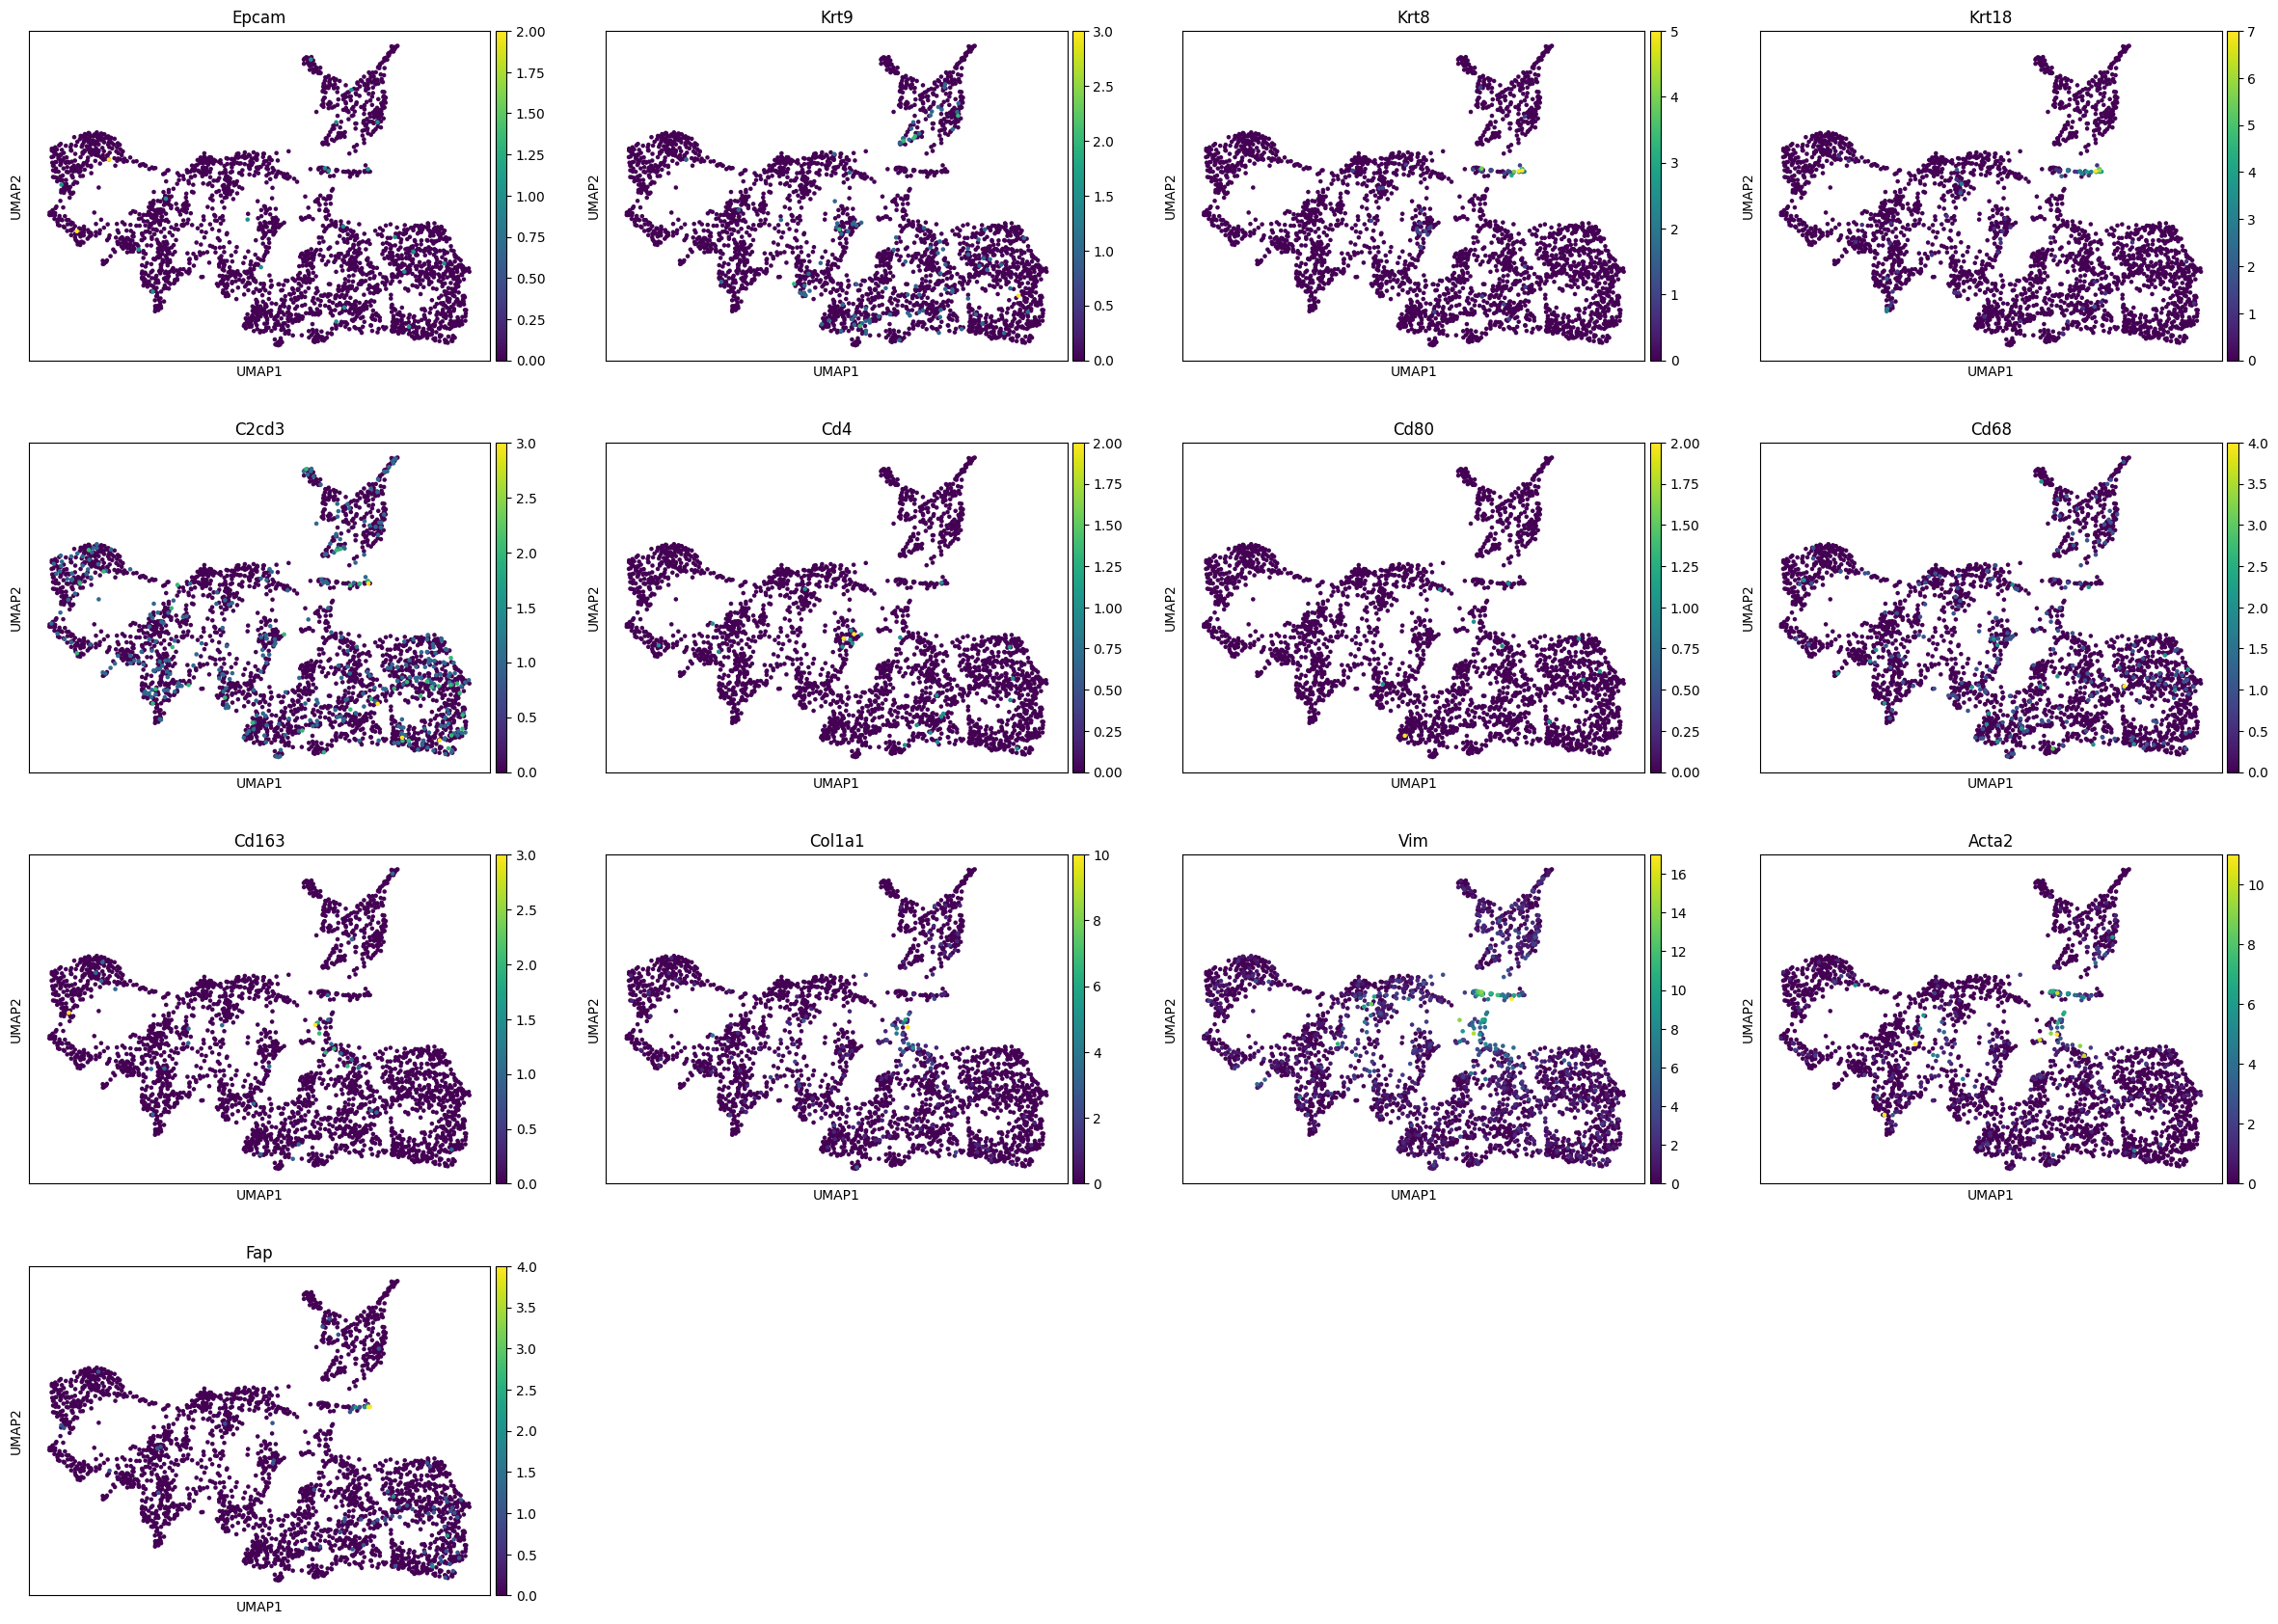

In [ ]:
sc.tl.umap(adata_bc)
sc.pl.embedding(
    adata_bc, basis="umap", color=tumor_markers + immune_markers + stromal_markers
)

<Figure size 1000x800 with 0 Axes>

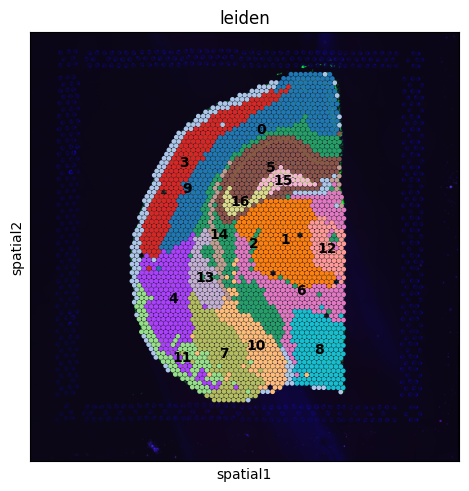

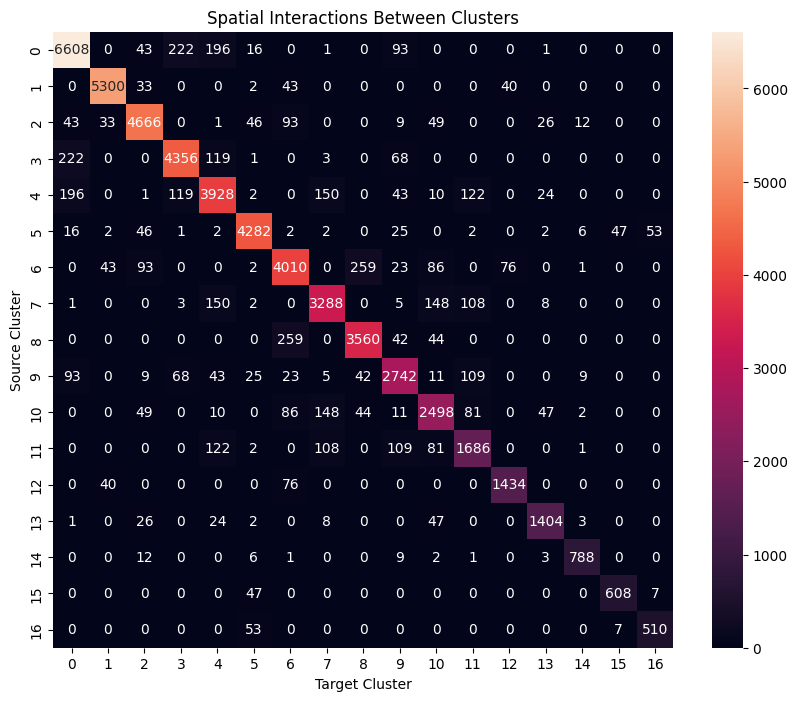

In [ ]:
# Compute neighborhood graph to analyze cell-cell interactions
sc.pp.neighbors(adata_bc, use_rep="X_pca")

# Find clusters/regions
sc.tl.leiden(adata_bc, resolution=0.8)

# Visualize clusters in spatial context
plt.figure(figsize=(10, 8))
sq.pl.spatial_scatter(adata_bc, color="leiden", size=1.5, legend_loc="on data")


# Compute interaction scores between regions
def compute_interactions(adata, cluster_key="leiden"):
    # Count neighbors of different clusters for each spot
    clusters = adata.obs[cluster_key].cat.categories
    n_clusters = len(clusters)

    # Get the indices of nearest neighbors from the connectivities matrix
    connectivity = adata.obsp["connectivities"]

    # Initialize interaction matrix
    interaction_matrix = np.zeros((n_clusters, n_clusters))

    # For each spot, count interactions with spots of different clusters
    for i in range(adata.n_obs):
        # Get the cluster of the current spot
        current_cluster = adata.obs[cluster_key].iloc[i]
        current_idx = np.where(clusters == current_cluster)[0][0]
        # Get indices of neighbors
        neighbors = connectivity[i].nonzero()[1]

        # Count neighbors by cluster
        for neighbor in neighbors:
            neighbor_cluster = adata.obs[cluster_key].iloc[neighbor]
            neighbor_idx = np.where(clusters == neighbor_cluster)[0][0]
            interaction_matrix[current_idx, neighbor_idx] += 1

    return interaction_matrix, clusters


# Compute and visualize interactions
interaction_matrix, cluster_names = compute_interactions(adata_bc)

# Visualize interaction matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    interaction_matrix,
    annot=True,
    fmt=".0f",
    xticklabels=cluster_names,
    yticklabels=cluster_names,
)
plt.title("Spatial Interactions Between Clusters")
plt.xlabel("Target Cluster")
plt.ylabel("Source Cluster")
plt.show()